In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Margaret Duff (STFC - UKRI)
#                   Laura Murgatroyd (STFC - UKRI)

# CIL Callbacks How To

Callbacks are an essential tool in many optimization frameworks, providing a flexible way to monitor and control the execution of algorithms. Similar to popular packages such as [`keras`](https://keras.io/api/callbacks/), [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize), and [`pytorch`](https://pytorch.org/tnt/stable/framework/callbacks.html), CIL utilizes callbacks that can be passed to the `run` method of an algorithm. These callbacks have access to the entire state of the algorithm, allowing them to perform a wide range of tasks—from logging and saving progress to implementing early stopping conditions. By integrating callbacks, users can enhance the flexibility, efficiency, and functionality of their algorithms.

In this demo, we explore the default behavior of callbacks in CIL and present a variety of example callbacks that can be customized to suit your needs. New callbacks are regularly added to CIL based on user requests, so be sure to check out the [documentation](https://tomographicimaging.github.io/CIL/nightly/optimisation/#callbacks) for the latest updates.

## Install CIL and set some defaults

In [3]:

from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer
import numpy as np
import matplotlib.pyplot as plt 
from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares,  TotalVariation
from cil.optimisation.utilities import callbacks
from cil.framework import DataContainer


# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'

## Load Data

In this example, we utilize CIL's simulated sphere data. To accelerate computations in this notebook, we extract a 2D slice from the 3D dataset. Additionally, we select a subset of angles to create a limited-angle reconstruction scenario. We will then compare the ground truth data with a filtered back projection (FBP) reconstruction under these limited-angle conditions.


New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.]
	Rotation axis position: [0., 0.]
	Detector position: [    0., 60000.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [128   1]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128)
New geometry shape:  (60, 128)
FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



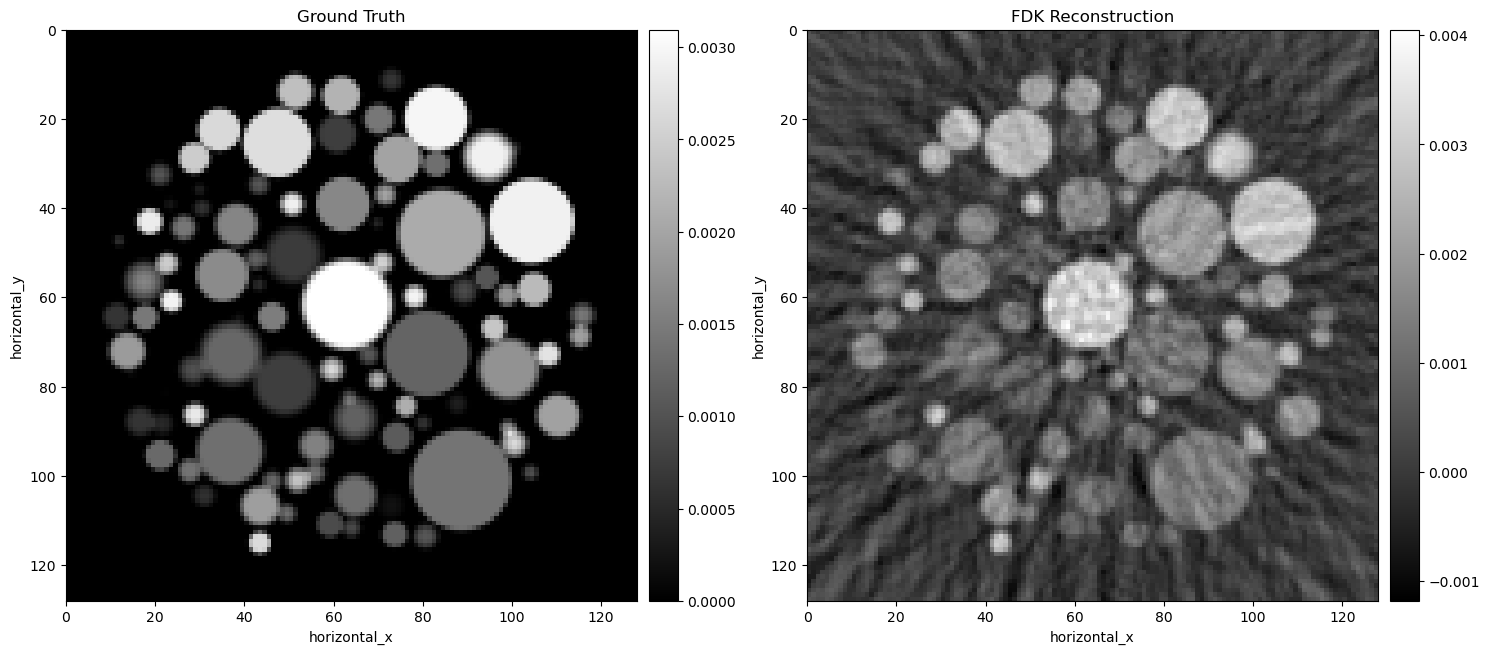

In [4]:
from cil.utilities import dataexample
# Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()

# Consider just a single 2D slice 
data = data.get_slice(vertical='centre')
ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()

show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)

## Default Behavior

When no callback is passed to the `run` method, a progress bar is automatically displayed. This progress bar provides useful information, including the time elapsed, estimated time remaining, iterations per second, and the current objective value. Keep in mind that the current objective value updates at intervals determined by the `update_objective_interval` parameter set in the algorithm.


  0%|          | 0/500 [00:00<?, ?it/s]

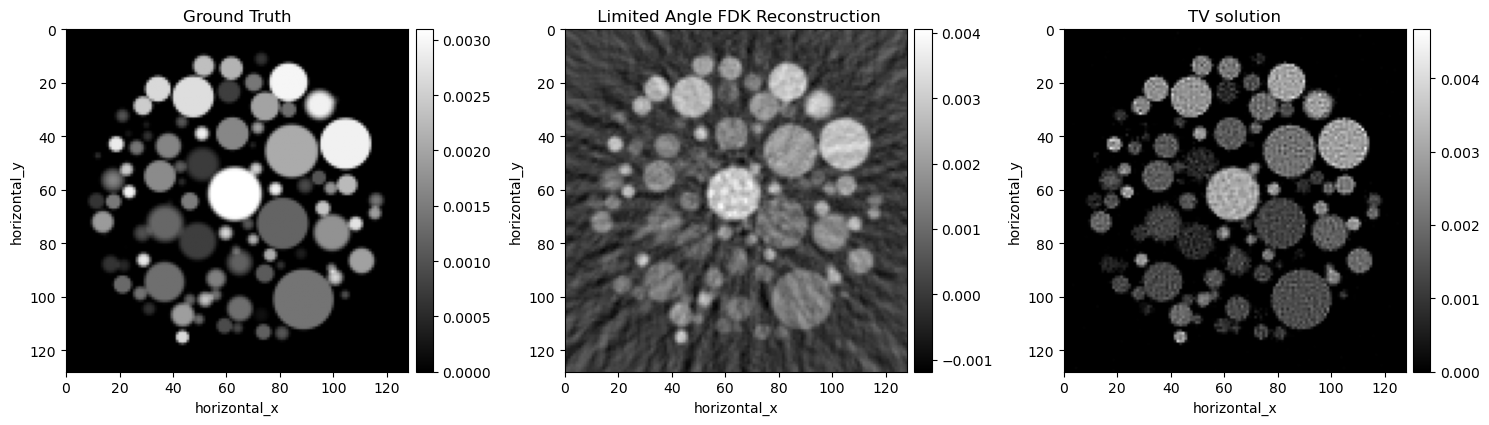

In [5]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = LeastSquares(A = A, b = absorption)
G = alpha*TotalVariation(lower=0)

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=1)
algo.run(500)
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', ' Limited Angle FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


## Available CIL Callbacks

Callbacks in CIL are provided as a list to the `run` method of an algorithm. In this example, we use two built-in CIL callbacks: `callbacks.ProgressCallback()` and `callbacks.TextProgressCallback()`. The first is the default callback that displays a progress bar, as demonstrated earlier. The second, `callbacks.TextProgressCallback()`, prints progress updates at intervals specified by `update_objective_interval`.

It's important to note that if you don't pass any callbacks, the default behavior is to display the progress bar. However, if you choose to include other callbacks and still want the progress bar, you must explicitly include `callbacks.ProgressCallback()` in your list.


Each callback is run at each iteration, after any `update` step is taken. In the following example, due to the design of the callback,  the display is only updated and/or printed every `update_objective_interval` but the callback is still called at each iteration.        

  0%|          | 0/500 [00:00<?, ?it/s]

     0/500        ?it/s


    10/500    26.65it/s, objective=+8.586e+01


    20/500    26.75it/s, objective=+9.047e+00


    30/500    26.76it/s, objective=+2.640e+00


    40/500    26.80it/s, objective=+1.188e+00


    50/500    26.73it/s, objective=+6.928e-01


    60/500    26.59it/s, objective=+4.585e-01


    70/500    26.63it/s, objective=+3.451e-01


    80/500    26.73it/s, objective=+2.741e-01


    90/500    26.74it/s, objective=+2.337e-01


   100/500    26.74it/s, objective=+2.062e-01


   110/500    26.77it/s, objective=+1.870e-01


   120/500    26.64it/s, objective=+1.729e-01


   130/500    26.65it/s, objective=+1.623e-01


   140/500    26.69it/s, objective=+1.541e-01


   150/500    26.70it/s, objective=+1.476e-01


   160/500    26.73it/s, objective=+1.421e-01


   170/500    26.71it/s, objective=+1.375e-01


   180/500    26.73it/s, objective=+1.336e-01


   190/500    26.71it/s, objective=+1.303e-01


   200/500    26.69it/s, objective=+1.275e-01


   210/500    26.67it/s, objective=+1.250e-01


   220/500    26.72it/s, objective=+1.228e-01


   230/500    26.77it/s, objective=+1.208e-01


   240/500    26.72it/s, objective=+1.190e-01


   250/500    26.73it/s, objective=+1.173e-01


   260/500    26.73it/s, objective=+1.159e-01


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 157, in display
    pbar.value = self.n
    ^^^^^^^^^^
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/bgb37

   270/500    26.52it/s, objective=+1.145e-01


   280/500    26.61it/s, objective=+1.134e-01


   290/500    26.63it/s, objective=+1.123e-01


   300/500    26.62it/s, objective=+1.113e-01


   310/500    26.55it/s, objective=+1.104e-01


   320/500    26.66it/s, objective=+1.096e-01


   330/500    26.66it/s, objective=+1.088e-01


   340/500    26.71it/s, objective=+1.081e-01


   350/500    26.74it/s, objective=+1.075e-01


   360/500    26.64it/s, objective=+1.068e-01


   370/500    26.70it/s, objective=+1.063e-01


   380/500    26.70it/s, objective=+1.057e-01


   390/500    26.77it/s, objective=+1.052e-01


   400/500    26.76it/s, objective=+1.048e-01


   410/500    26.77it/s, objective=+1.043e-01


   420/500    26.78it/s, objective=+1.039e-01


   430/500    26.82it/s, objective=+1.035e-01


   440/500    26.80it/s, objective=+1.031e-01


   450/500    26.78it/s, objective=+1.028e-01


   460/500    26.77it/s, objective=+1.025e-01


   470/500    26.84it/s, objective=+1.022e-01


   480/500    26.87it/s, objective=+1.019e-01


   490/500    26.85it/s, objective=+1.016e-01


   500/500    26.85it/s, objective=+1.013e-01


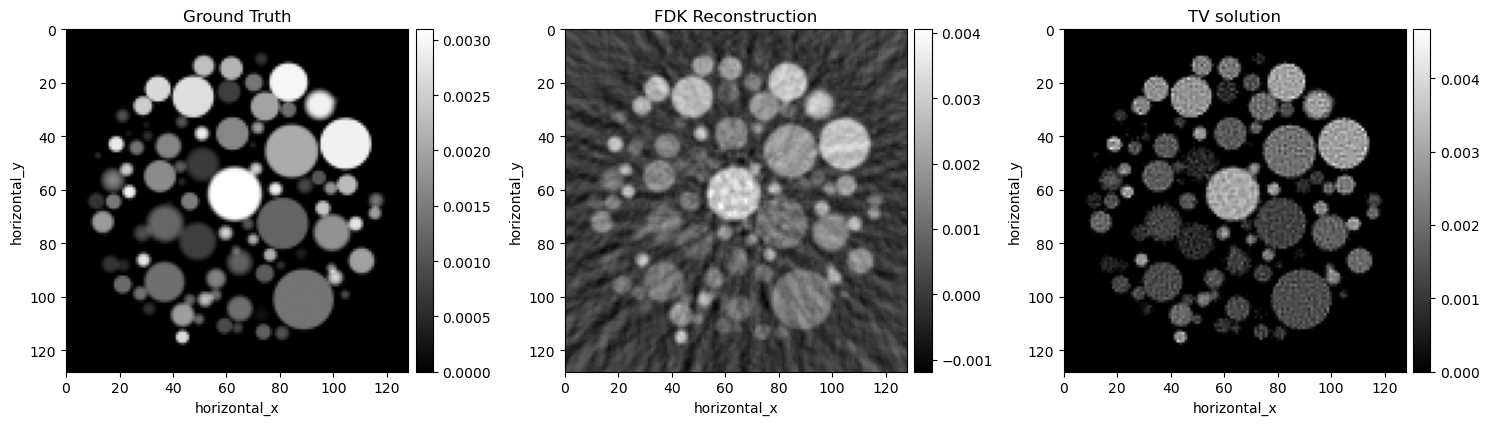

In [6]:
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)
cb1=callbacks.ProgressCallback()
cb2=callbacks.TextProgressCallback()
algo.run(500, callbacks=[cb1, cb2])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

When you call the algorithm's `run` method again, it resumes from where it left off. To start fresh, you should redefine both the algorithm and the callbacks.


In [7]:
algo.run(100, callbacks=[cb1, cb2])

   510/?      18.52it/s, objective=+1.011e-01


   520/?      20.49it/s, objective=+1.008e-01


   530/?      22.09it/s, objective=+1.006e-01


   540/?      23.38it/s, objective=+1.004e-01


   550/?      24.38it/s, objective=+1.002e-01


   560/?      25.14it/s, objective=+1.000e-01


   570/?      25.68it/s, objective=+9.986e-02


   580/?      26.08it/s, objective=+9.969e-02


   590/?      26.36it/s, objective=+9.953e-02


   600/?      26.58it/s, objective=+9.938e-02


## Early Stopping (Custom Callback Example)

To create your own callback, define a class with a `__call__` method. It's a good practice to subclass the CIL `callbacks.Callback` class. The `__call__` method should take `self` and `algorithm` as arguments, where `algorithm` is an initialized CIL algorithm. This allows the callback to access and utilize any properties stored within the algorithm.

In this example, the callback raises a `StopIteration` exception if a specified stopping criterion is met, forcing the algorithm to terminate early. In this basic case, it stops if the algorithm objective is less than 0.2. You can see that the algorithm does not run for the full 500 iterations. 


     0/500        ?it/s


    10/500    27.00it/s, objective=+8.586e+01


    20/500    27.12it/s, objective=+9.047e+00


    30/500    27.28it/s, objective=+2.640e+00


    40/500    27.27it/s, objective=+1.188e+00


    50/500    27.30it/s, objective=+6.928e-01


    60/500    27.30it/s, objective=+4.585e-01


    70/500    27.29it/s, objective=+3.451e-01


    80/500    27.32it/s, objective=+2.741e-01


    90/500    27.33it/s, objective=+2.337e-01


   100/500    27.29it/s, objective=+2.062e-01


   110/500    27.22it/s, objective=+1.870e-01


   110/500    27.25it/s


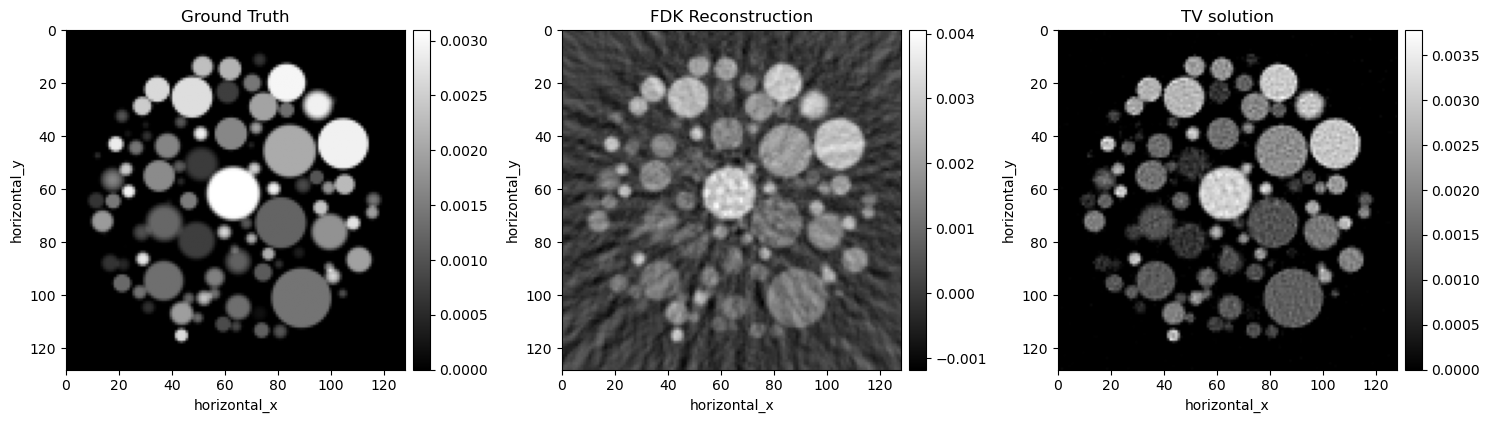

In [8]:
class EarlyStoppingObjective(callbacks.Callback):
      
         def __call__(self, algorithm):
               if algorithm.objective[-1] <= 2e-1:  # arbitrary stopping criterion
                  raise StopIteration

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[callbacks.TextProgressCallback(), EarlyStoppingObjective()])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


In another early stopping example, the algorithm terminates when the current solution approaches a given reference image. This example demonstrates a callback that accepts arguments upon initialization, allowing for more flexible and customized stopping criteria. It terminates when the mean square difference between the current solution and a provided reference image is equal to or less than a provided tolerance.


     0/500        ?it/s


    10/500    24.91it/s, objective=+8.586e+01


    20/500    26.05it/s, objective=+9.047e+00


    22/500    26.00it/s


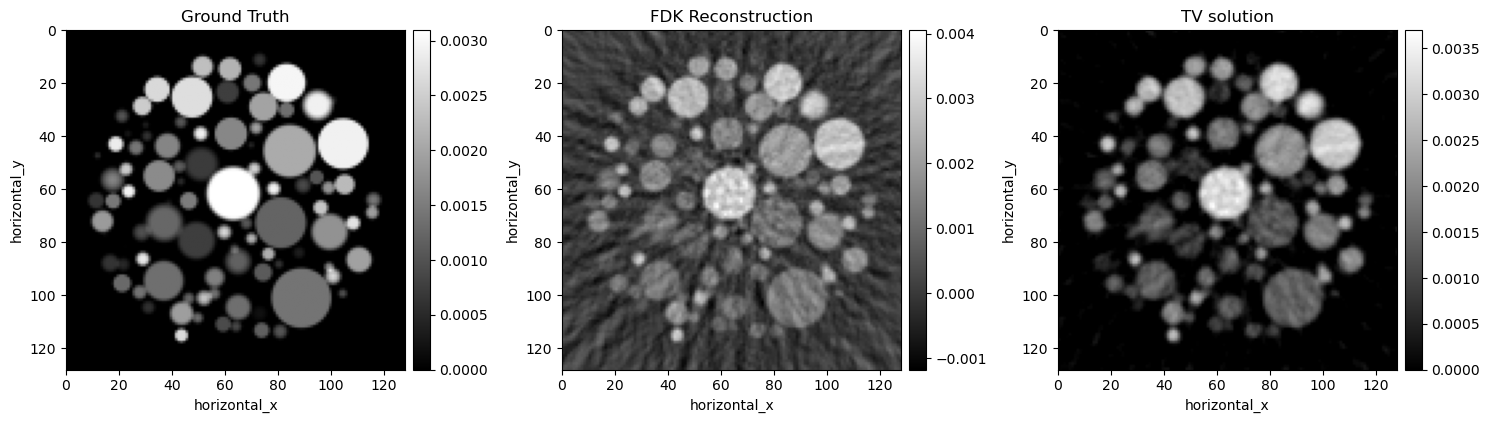

In [9]:
class EarlyStoppingReference(callbacks.Callback):
      """ 
      Terminates the algorithm when the mean square difference between the current solution and a provided reference image is equal to or less than a provided tolerance.
     
      Parameters
      ----------

      ref_img: ImageData
            The image to compare the iterates to. The algorithm will terminate if the current solution satisfies :math:`\frac{1}{N}||x-ref_img||_2^2<tol`, where :math:`N` is the number of pixels in the image.
      tolerance: float, default 1e-8
            A small value which determines the sensitivity of this stopping criterion. The algorithm will terminate if the current solution satisfies :math:`\frac{1}{N}||x-ref_img||_2^2<tol`, where :math:`N` is the number of pixels in the image.
      """
      
      def __init__(self, ref_img, tolerance=1e-8):
            self.ref=ref_img
            self.tol=tolerance
      def __call__(self, algorithm):
            if np.mean((algorithm.solution.array-self.ref.array)**2) <= self.tol:  
                  raise StopIteration

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)
cb=EarlyStoppingReference(ground_truth, 3e-8)         
algo.run(500, callbacks=[callbacks.TextProgressCallback(),cb ])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

## Calculating Data Discrepancy at Each Iteration (Custom Callback Example)

In this example, a custom metric —specifically a least squares data discrepancy calculation— is computed at the end of each iteration and stored within the callback. We demonstrate how to initialize two callbacks to save the results from two different methods: FISTA with TV, with and without non-negativity enforced. The results are then plotted for comparison.


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/bgb3

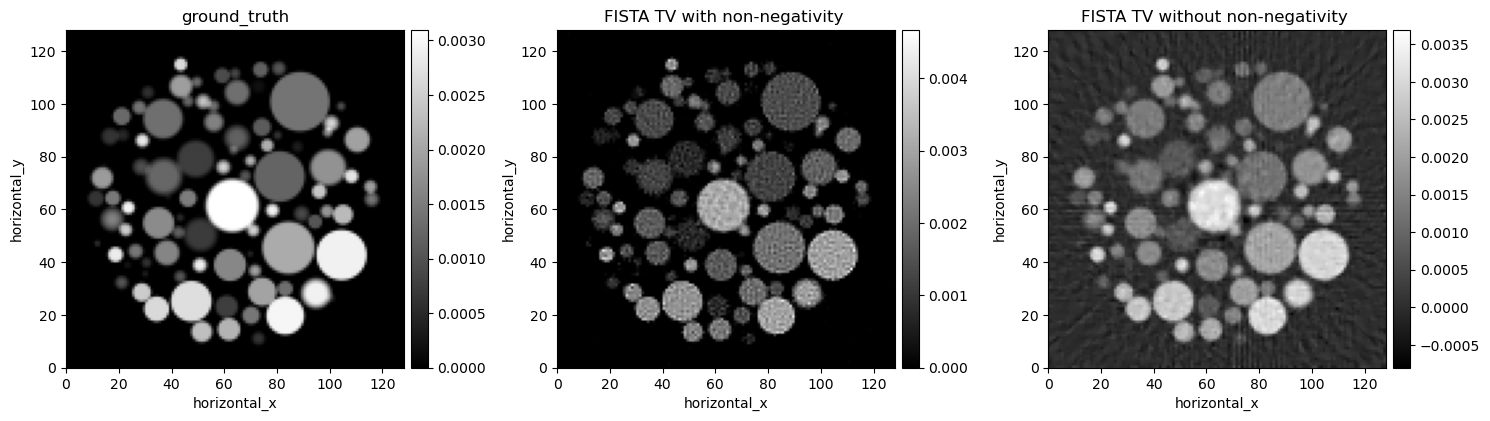

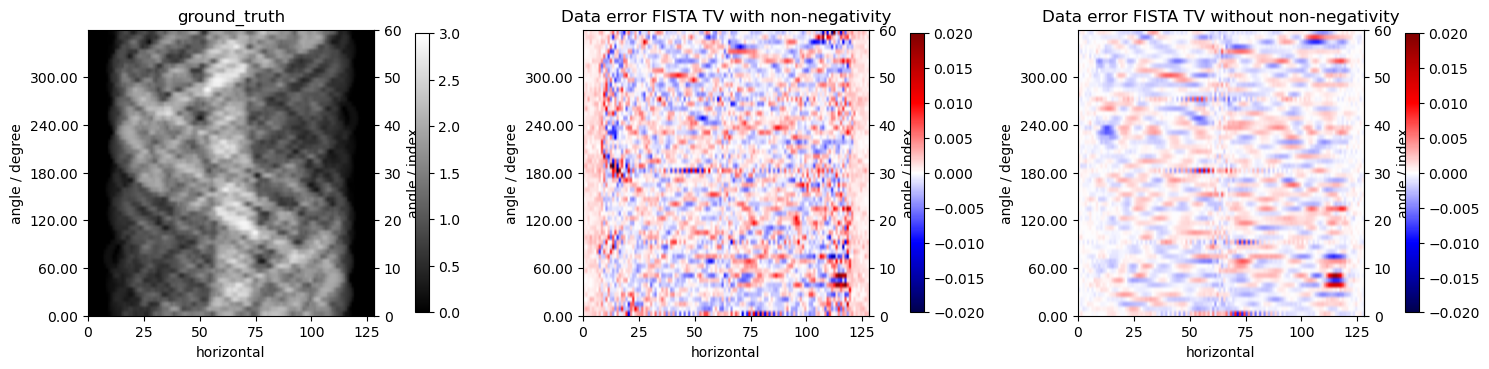

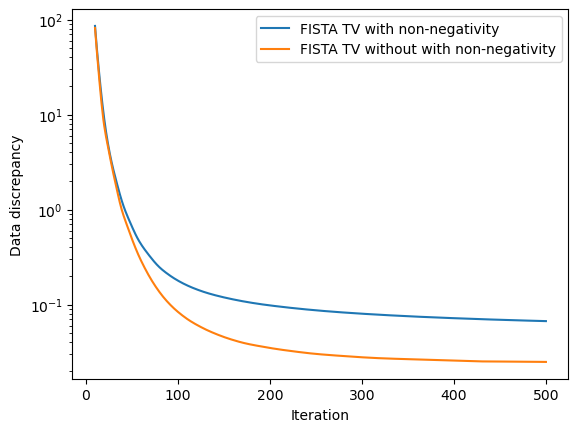

In [10]:
class LeastSquaresCallback(callbacks.Callback):
    """
    Parameters
    ----------

    A : Operator
      The forward operator for the least squares calculation 
    data: DataContainer
      Acquisition data for the least squares calculation 
      
    Properties
    ----------
    save_values: list of floats 
      The saved least squares calculation, one per iteration
      
    """
    
    def __init__(self, A, data):
        self.f = LeastSquares(A, data)
        self.save_values=[]
    
    def __call__(self, algorithm):
        self.save_values.append(self.f(algorithm.get_output()))

mycallback_FISTA_lower_bound= LeastSquaresCallback(A, absorption)
algo1=FISTA(initial=ig.allocate(0), f=F, g=alpha*TotalVariation(lower=0), update_objective_interval=10)         
algo1.run(500, callbacks=[mycallback_FISTA_lower_bound])

        
mycallback_FISTA_no_lower_bound= LeastSquaresCallback(A, absorption)
algo2=FISTA(initial=ig.allocate(0), f=F, g=alpha*TotalVariation(), update_objective_interval=10)         
algo2.run(500, callbacks=[mycallback_FISTA_no_lower_bound])


show2D([ground_truth, algo1.get_output(), algo2.get_output()], title=['ground_truth', 'FISTA TV with non-negativity ', 'FISTA TV without non-negativity '], num_cols=3)
show2D([absorption, A.direct(algo1.get_output())-absorption, A.direct(algo2.get_output())-absorption], title=['ground_truth', 'Data error FISTA TV with non-negativity', 'Data error FISTA TV without non-negativity'], fix_range=[[0,3], [-0.02, 0.02], [-0.02, 0.02]], cmap=['gray', 'seismic', 'seismic'], num_cols=3)
plt.plot(range(10,501), mycallback_FISTA_lower_bound.save_values[10:], label='FISTA TV with non-negativity ')
plt.plot(range(10, 501), mycallback_FISTA_no_lower_bound.save_values[10:], label='FISTA TV without with non-negativity')
plt.yscale('log')
plt.ylabel('Data discrepancy')
plt.xlabel('Iteration')
plt.legend()

We see that the without the  non-negativity, the reconstruction overfits to the noisy absorption data. 

## Calculating a Noise Approximation for Each Iteration (Custom Callback Example)

In this example, we define a custom callback that saves the values of a wavelet-based estimator of Gaussian noise standard deviation, provided by `skimage`, at each iteration. Using TV regularization and a FISTA optimization algorithm with non-negativity, we compare how the noise level in the solution changes for two different regularization parameters: a small value (0.1) and a larger value (1).


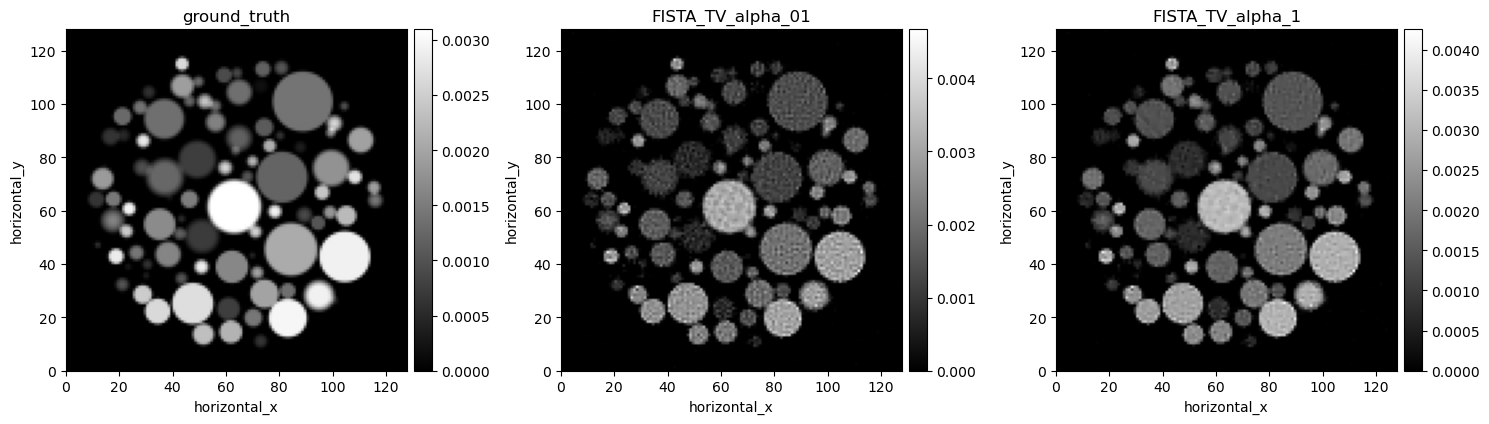

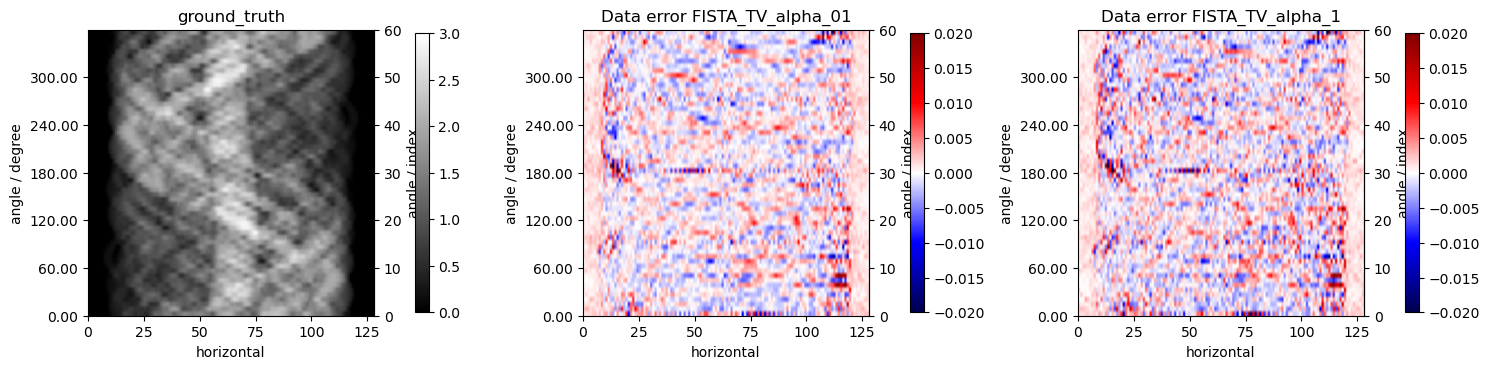

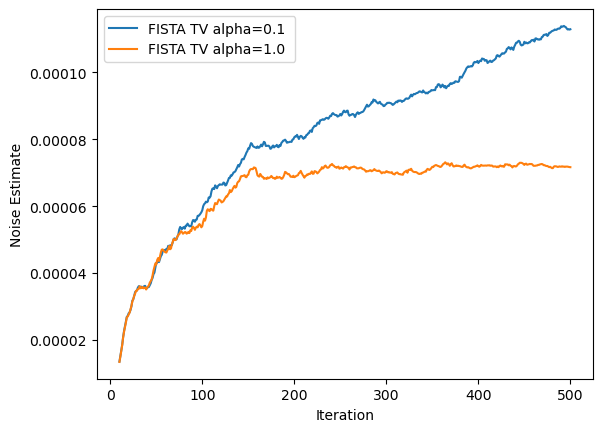

In [11]:
import skimage

class SigmaEstimateCallback(callbacks.Callback):
    """
    Properties
    ----------
    save_values: list of floats 
      The saved sigma calculation, one per iteration
      
    """
    
    def __init__(self):

        self.save_values=[]

    def __call__(self, algorithm):
        self.save_values.append(skimage.restoration.estimate_sigma(algorithm.get_output().as_array()))

mycallback_FISTA_TV_alpha_01= SigmaEstimateCallback()
algo1=FISTA(initial=ig.allocate(0), f=F, g=0.1*TotalVariation(lower=0), update_objective_interval=10)         
algo1.run(500, callbacks=[mycallback_FISTA_TV_alpha_01])

        
mycallback_FISTA_TV_alpha_1= SigmaEstimateCallback()
algo2=FISTA(initial=ig.allocate(0), f=F, g=1*TotalVariation(lower=0), update_objective_interval=10)         
algo2.run(500, callbacks=[mycallback_FISTA_TV_alpha_1])


show2D([ground_truth, algo1.get_output(), algo2.get_output()], title=['ground_truth', 'FISTA_TV_alpha_01', 'FISTA_TV_alpha_1'], num_cols=3)
show2D([absorption, A.direct(algo1.get_output())-absorption, A.direct(algo2.get_output())-absorption], title=['ground_truth', 'Data error FISTA_TV_alpha_01', 'Data error FISTA_TV_alpha_1'], fix_range=[[0,3], [-0.02, 0.02], [-0.02, 0.02]], cmap=['gray', 'seismic', 'seismic'], num_cols=3)
plt.plot(range(10,501), mycallback_FISTA_TV_alpha_01.save_values[10:], label='FISTA TV alpha=0.1 ')
plt.plot(range(10, 501), mycallback_FISTA_TV_alpha_1.save_values[10:], label='FISTA TV alpha=1.0 ')
plt.ylabel('Noise Estimate')
plt.xlabel('Iteration')
plt.legend()
                                   
                            

We see with a larger regularisation parameter, the resulting image is less noisy. 

## Image metric callbacks (complex custom callback example) 
We now move on to some more complex callbacks. In this callback, a dictionary of metrics are calculated and printed each `print_interval`.  For more information on the metrics in CIL see the documentation: https://tomographicimaging.github.io/CIL/nightly/utilities/#module-cil.utilities.quality_measures. 

In [12]:

class MetricsDiagnostics(callbacks.Callback):
    """
    Parameters
    ----------

    reference_image: CIL or STIR ImageData
      containing the reference image used to calculate the metrics
      
    metrics_dict : dictionary of lambda functions f(x,y) mapping
      two 1-dimensional numpy arrays x and y to a scalar value or a
      numpy.ndarray.
      x and y are the voxel values of the whole image. 
      E.g. f(x,y) could be MSE(x,y), PSNR(x,y), MAE(x,y)
      
    print_interval: positive integer
        The results are calculated and printed every `print_interval` number of iterations 


    """

    def __init__(self, reference_image, metrics_dict, print_interval=1):

        self.reference_image = reference_image      
        self.metrics_dict = metrics_dict
        self.computed_metrics = []    
        self.print_interval=print_interval

        super(MetricsDiagnostics, self).__init__()  

    def __call__(self, algo):

            
        for metric_name, metric_func in self.metrics_dict.items():

            if not hasattr(algo, metric_name):
                setattr(algo, metric_name, [])   
                
            metric_list = getattr(algo, metric_name)
            metric_value = metric_func(self.reference_image, algo.get_output())
            metric_list.append(metric_value)
            
            self.computed_metrics.append(metric_value)
            
        if algo.iteration == 0:
                    
            print (self.callback_header())
        
        print(self.callback_iteration())  
            
               
    def callback_header(self):
        return " ".join("{:>20}".format(metric_name) for metric_name in self.metrics_dict.keys())

    def callback_iteration(self):
        if isinstance(self.computed_metrics, list):
            # Handle list of metrics
            return " ".join("{:>20.5e}".format(metric) for metric in self.computed_metrics[-len(self.metrics_dict):])
        else:
            # Handle single metric
            return "{:>20.5e}".format(self.computed_metrics)     
        

from cil.utilities.quality_measures import mae, psnr, mse 
metric_callback= MetricsDiagnostics(ground_truth, {'MSE':mse, 'MAE':mae, 'PSNR':psnr})
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(100, callbacks=[metric_callback])

                 MSE                  MAE                 PSNR
         1.07888e-06          5.48145e-04          9.48530e+00
         5.85316e-07          6.22034e-04          1.21411e+01
         5.05844e-07          5.72563e-04          1.27749e+01
         4.31374e-07          5.19819e-04          1.34665e+01
         3.64704e-07          4.67054e-04          1.41956e+01
         3.06416e-07          4.16492e-04          1.49519e+01


         2.56388e-07          3.70092e-04          1.57261e+01
         2.14156e-07          3.28810e-04          1.65077e+01
         1.78987e-07          2.92725e-04          1.72868e+01
         1.50022e-07          2.60981e-04          1.80535e+01
         1.26383e-07          2.33361e-04          1.87981e+01
         1.07187e-07          2.09652e-04          1.95136e+01


         9.16141e-08          1.89309e-04          2.01954e+01
         7.89449e-08          1.72049e-04          2.08418e+01
         6.85910e-08          1.57283e-04          2.14524e+01
         6.00884e-08          1.44610e-04          2.20271e+01
         5.30737e-08          1.33746e-04          2.25662e+01
         4.72670e-08          1.24414e-04          2.30695e+01


         4.24393e-08          1.16364e-04          2.35374e+01
         3.84176e-08          1.09415e-04          2.39697e+01
         3.50543e-08          1.03451e-04          2.43676e+01
         3.22300e-08          9.82989e-05          2.47324e+01
         2.98493e-08          9.39156e-05          2.50657e+01
         2.78304e-08          9.01341e-05          2.53698e+01


         2.61075e-08          8.68680e-05          2.56474e+01
         2.46249e-08          8.40164e-05          2.59013e+01
         2.33423e-08          8.14809e-05          2.61336e+01
         2.22266e-08          7.92211e-05          2.63463e+01
         2.12462e-08          7.72332e-05          2.65422e+01
         2.03792e-08          7.54337e-05          2.67232e+01


         1.96080e-08          7.38151e-05          2.68907e+01
         1.89173e-08          7.23520e-05          2.70464e+01
         1.82934e-08          7.10307e-05          2.71921e+01
         1.77264e-08          6.98001e-05          2.73288e+01
         1.72101e-08          6.86725e-05          2.74572e+01
         1.67384e-08          6.76756e-05          2.75779e+01


         1.63068e-08          6.67997e-05          2.76913e+01
         1.59109e-08          6.59966e-05          2.77981e+01
         1.55498e-08          6.52429e-05          2.78978e+01
         1.52208e-08          6.45565e-05          2.79907e+01
         1.49199e-08          6.39012e-05          2.80774e+01
         1.46448e-08          6.32730e-05          2.81582e+01


         1.43935e-08          6.26837e-05          2.82334e+01
         1.41640e-08          6.21308e-05          2.83032e+01
         1.39533e-08          6.16084e-05          2.83683e+01
         1.37602e-08          6.11234e-05          2.84288e+01
         1.35827e-08          6.06740e-05          2.84852e+01
         1.34200e-08          6.02613e-05          2.85375e+01


         1.32710e-08          5.98831e-05          2.85860e+01
         1.31342e-08          5.95366e-05          2.86310e+01
         1.30086e-08          5.92132e-05          2.86727e+01
         1.28936e-08          5.89066e-05          2.87113e+01
         1.27882e-08          5.86154e-05          2.87469e+01
         1.26929e-08          5.83402e-05          2.87794e+01


         1.26069e-08          5.81077e-05          2.88090e+01
         1.25294e-08          5.79025e-05          2.88357e+01
         1.24593e-08          5.77139e-05          2.88601e+01
         1.23964e-08          5.75408e-05          2.88821e+01
         1.23400e-08          5.73717e-05          2.89019e+01
         1.22899e-08          5.72179e-05          2.89196e+01


         1.22457e-08          5.70800e-05          2.89352e+01
         1.22065e-08          5.69476e-05          2.89491e+01
         1.21716e-08          5.68220e-05          2.89616e+01
         1.21399e-08          5.67079e-05          2.89729e+01
         1.21121e-08          5.66082e-05          2.89828e+01
         1.20881e-08          5.65168e-05          2.89914e+01


         1.20672e-08          5.64386e-05          2.89990e+01
         1.20490e-08          5.63735e-05          2.90055e+01
         1.20338e-08          5.63197e-05          2.90110e+01
         1.20213e-08          5.62742e-05          2.90155e+01
         1.20117e-08          5.62335e-05          2.90190e+01
         1.20049e-08          5.61994e-05          2.90214e+01


         1.20006e-08          5.61720e-05          2.90230e+01
         1.19991e-08          5.61517e-05          2.90236e+01
         1.19998e-08          5.61385e-05          2.90233e+01
         1.20029e-08          5.61309e-05          2.90222e+01
         1.20088e-08          5.61240e-05          2.90201e+01
         1.20170e-08          5.61242e-05          2.90171e+01


         1.20275e-08          5.61325e-05          2.90133e+01
         1.20408e-08          5.61499e-05          2.90085e+01
         1.20565e-08          5.61750e-05          2.90028e+01
         1.20747e-08          5.62071e-05          2.89963e+01
         1.20954e-08          5.62404e-05          2.89888e+01
         1.21182e-08          5.62744e-05          2.89806e+01


         1.21432e-08          5.63137e-05          2.89717e+01
         1.21702e-08          5.63569e-05          2.89620e+01
         1.21990e-08          5.64026e-05          2.89518e+01
         1.22294e-08          5.64532e-05          2.89410e+01
         1.22611e-08          5.65052e-05          2.89297e+01
         1.22934e-08          5.65577e-05          2.89183e+01


         1.23272e-08          5.66136e-05          2.89064e+01
         1.23621e-08          5.66716e-05          2.88941e+01
         1.23983e-08          5.67352e-05          2.88814e+01
         1.24357e-08          5.68040e-05          2.88683e+01
         1.24743e-08          5.68758e-05          2.88549e+01
         1.25140e-08          5.69482e-05          2.88411e+01


         1.25548e-08          5.70229e-05          2.88269e+01
         1.25965e-08          5.71005e-05          2.88125e+01
         1.26388e-08          5.71802e-05          2.87980e+01
         1.26821e-08          5.72615e-05          2.87831e+01
         1.27264e-08          5.73452e-05          2.87680e+01


## Image metric callbacks with region of interest (complex custom callback example) 

For another complex example. This callback takes a reference image, region of interest mask and a dictionary of metrics and a dictionary of statistics to evaluate at each iteration. We define some regions of interest and then can plot the metrics for the different regions of interest. 

In [13]:
class ImageQualityCallback(callbacks.Callback):
    """
    Parameters
    ----------

    reference_image: CIL or STIR ImageData
      containing the reference image used to calculate the metrics

    roi_mask_dict : dictionary of ImageData objects. Optional - default is None 
      list containing one binary ImageData object for every ROI to be
      evaluated. Voxels with values 1 are considered part of the ROI
      and voxels with value 0 are not.
      Dimension of the ROI mask images must be the same as the dimension of
      the reference image.

    metrics_dict : dictionary of lambda functions f(x,y) mapping  
      two 1-dimensional numpy arrays x and y to a scalar value or a
      numpy.ndarray. Optional - default is None.
        x and y can be the voxel values of the whole images or the values of
        voxels in a ROI such that the metric can be computed on the whole
        images and optionally in the ROIs separately. 
        E.g. f(x,y) could be MSE(x,y), PSNR(x,y), MAE(x,y)

    statistics_dict : dictionary of lambda functions f(x) mapping a 
      1-dimensional numpy array x to a scalar value or a numpy.ndarray. Optional - default is None 
        E.g. mean(x), std_deviation(x) that calculate global and / or
        ROI mean and standard deviations. 

    Properties
    ----------
    metric_store: dictionary
      The keys of the dictionary are "global_"+metric keys or roi key +'_'+ metric key. Stored under these keys is a list of calculations of the metric for that roi, one per iteration.  
      
    stat_store: dictionary
      The keys of the dictionary are "global_"+statistic keys or roi key +'_'+ statistic key. Stored under these keys is a list of calculations of the statistic for that roi, one per iteration.  

      """

    def __init__(self, reference_image,
                 roi_mask_dict=None,
                 metrics_dict=None,
                 statistics_dict=None
                 ):

        # the reference image
        self.reference_image = reference_image

        self.roi_indices_dict = {}
        self.roi_store = []

        self.roi_mask_dict = roi_mask_dict

        self.metrics_dict = metrics_dict
        self.metrics_store = {}
        for key in self.metrics_dict:
            self.metrics_store['global_'+key] = []
            if roi_mask_dict is not None:
                for roi_name in roi_mask_dict:
                    self.metrics_store[roi_name+'_'+key] = []

        self.statistics_dict = statistics_dict
        self.stat_store = {}
        for key in self.statistics_dict:
            self.stat_store['global_'+key] = []
            if roi_mask_dict is not None:
                for roi_name in roi_mask_dict:
                    self.stat_store[roi_name+'_'+key] = []

    def __call__(self, algorithm):
        if self.metrics_dict is not None:
            for metric_name, metric in self.metrics_dict.items():
                ans = metric(self.reference_image, algorithm.x)
                self.metrics_store['global_'+metric_name].append(ans)

                for roi_name, roi in self.roi_mask_dict.items():
                    ans = metric(self.reference_image, algorithm.x, mask=roi)
                    self.metrics_store[roi_name+'_'+metric_name].append(ans)

        if self.statistics_dict is not None:
            for statistic_name, stat in self.statistics_dict.items():
                ans = stat(algorithm.x.array, np._NoValue)
                self.stat_store['global_'+statistic_name].append(ans)

                for roi_name, roi in self.roi_mask_dict.items():
                    ans = stat(algorithm.x.array, roi.array.astype('bool'))
                    self.stat_store[roi_name+'_'+statistic_name].append(ans)

For this data we take one region of interest to be the brightest spheres, another region of interest the darkest spheres. We define the masks for this in the next cell: 

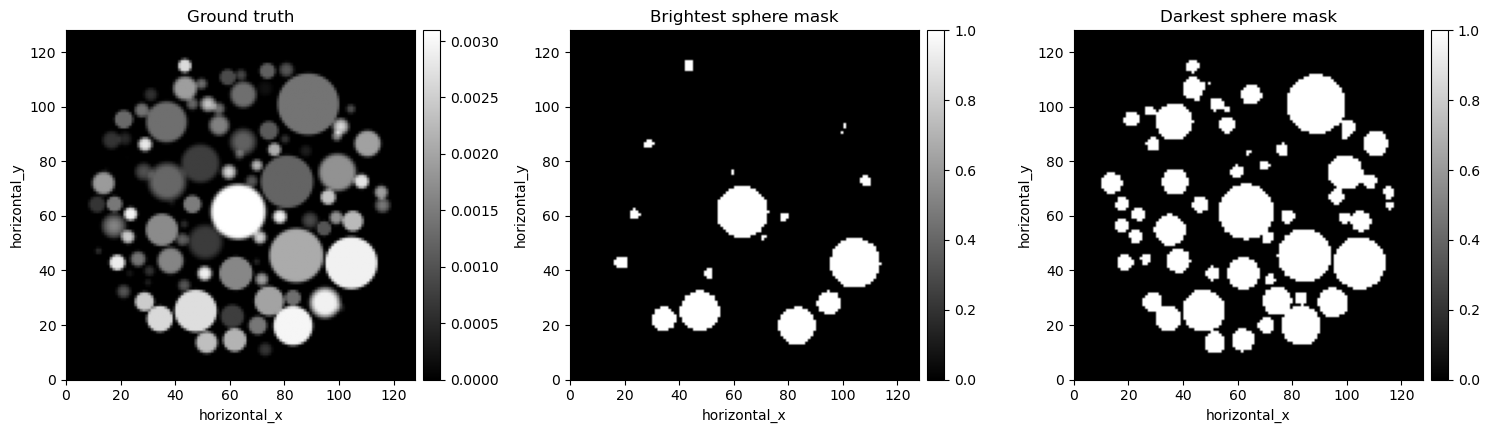

In [14]:
brightest = ig.allocate(0)
darkest = ig.allocate(0)

brightest.fill(
    np.asarray(ground_truth.array > 0.8 * ground_truth.max(), 
               dtype=np.float32)
    )
darkest.fill(
    np.asarray(np.invert(ground_truth.array < 0.4 * ground_truth.max()), 
               dtype=np.float32)
)



roi_image_dict = {
    'brightest' : brightest,
    'darkest' : darkest
}

show2D([ground_truth, brightest, darkest], title=["Ground truth", "Brightest sphere mask", "Darkest sphere mask"], num_cols=3)

In [15]:
from cil.utilities.quality_measures import mae, psnr, mse 
img_qual_callback = ImageQualityCallback(ground_truth,
                                              roi_mask_dict = roi_image_dict,
                                              metrics_dict = {'MSE':mse, 
                                                              'MAE':mae, 
                                                              'PSNR':psnr},
                                              statistics_dict = {'MEAN': (lambda x, y: np.mean(x, where=y)),
                                                                 'STDDEV': (lambda x, y: np.std(x, where=y)),
                                                                 'MAX': (lambda x, y: np.max(x, where=y, initial=0))},
                                              )

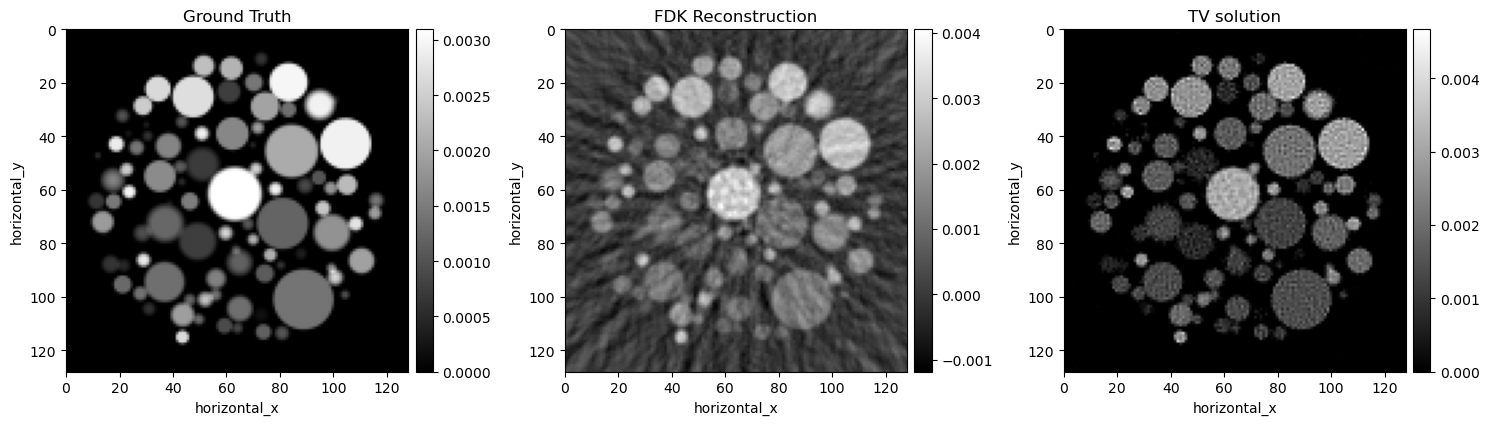

In [16]:
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[img_qual_callback])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

We see that over the whole image, the mean squared error initially decreases, but then eventually starts to overfit to the noise in the data. 

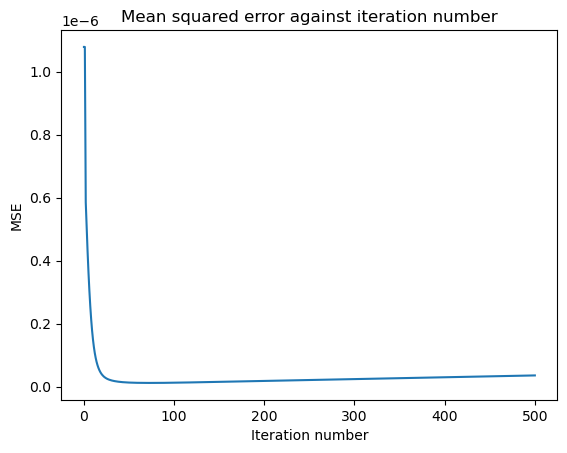

In [17]:
plt.plot(range(501), img_qual_callback.metrics_store['global_MSE'])
plt.ylabel('MSE')
plt.xlabel('Iteration number')
plt.title('Mean squared error against iteration number')
plt.show()


Similarly PSNR for the whole image, and for each of the regions of interest, initially increases to a peak at about 60-70 iterations then begins to decrease again. We can see that the PSNR over the whole image is greater than the regions of interest, suggesting that the algorithm is fitting the background well but not reconstructing the spheres as well. 

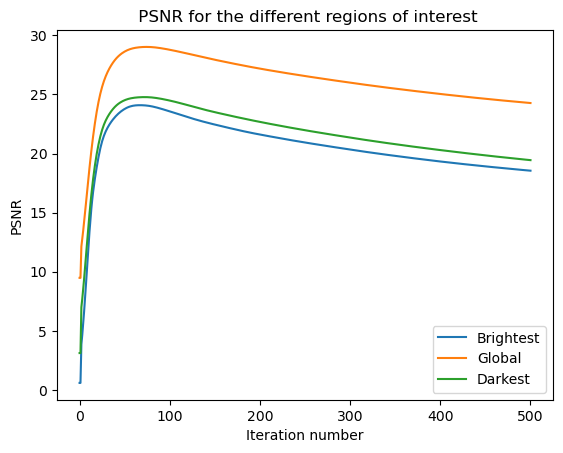

In [18]:
plt.plot(range(501), img_qual_callback.metrics_store['brightest_PSNR'], label='Brightest')
plt.plot(range(501), img_qual_callback.metrics_store['global_PSNR'], label='Global')
plt.plot(range(501), img_qual_callback.metrics_store['darkest_PSNR'], label='Darkest')
plt.xlabel('Iteration number')
plt.ylabel('PSNR')
plt.title(' PSNR for the different regions of interest')
plt.legend()